# Classify satellite images into landslide footprints 
If everything worked so far, we can then move on to actually classify an image provided we have enough confidence in the trained model. In this section, we will now load an image that we truly want to classify for real-world applications.

*Version: 0.2*

*Code update*
1. No need for patch generation
2. New stitching strategy with overlaps to avoid boundary artifacts
3. Generate shapefiles directly

In [1]:
%load_ext autotime

from osgeo import gdal
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
from keras.models import load_model
from rasterio.features import shapes
import rasterio
import tensorflow as tf
from tensorflow.keras.layers import *
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

from utils import *
from losses import *
from attention_Unets import *

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Segmentation Models: using `keras` framework.
time: 11.1 s (started: 2022-06-06 14:14:31 +02:00)


## Model Configuration

In [2]:
#Pre-requisite codes for loading the model

def accuracy(y_true, y_pred, threshold=0.5):
    """compute accuracy"""
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    y_pred = K.round(y_pred +0.5 - threshold)
    return K.equal(K.round(y_true), K.round(y_pred))

def dice_coef(y_true, y_pred, smooth=0.0000001):
    """compute dice coef"""
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1)
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=-1)

def dice_loss(y_true, y_pred):
    """compute dice loss"""
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    return 1 - dice_coef(y_true, y_pred)

# K.round() returns the Element-wise rounding to the closest integer!!!
# So the threshold to determine a true positive is set here!!!!!
def true_positives(y_true, y_pred, threshold=0.5):
    """compute true positive"""
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    y_pred = K.round(y_pred +0.5 - threshold)
    return K.round(y_true * y_pred)

def false_positives(y_true, y_pred, threshold=0.5):
    """compute false positive"""
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    y_pred = K.round(y_pred +0.5 - threshold)
    return K.round((1 - y_true) * y_pred)

def true_negatives(y_true, y_pred, threshold=0.5):
    """compute true negative"""
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    y_pred = K.round(y_pred +0.5 - threshold)
    return K.round((1 - y_true) * (1 - y_pred))

def false_negatives(y_true, y_pred, threshold=0.5):
    """compute false negative"""
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    y_pred = K.round(y_pred +0.5 - threshold)
    return K.round((y_true) * (1 - y_pred))

# K.sum() returns a single integer output unlike the K.round() which returns an element-wise matrix
def sensitivity(y_true, y_pred):
    """compute sensitivity (recall)"""
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    tp = true_positives(y_true, y_pred)
    fn = false_negatives(y_true, y_pred)
    return K.sum(tp) / (K.sum(tp) + K.sum(fn))

def specificity(y_true, y_pred):
    """compute specificity ()"""
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    tn = true_negatives(y_true, y_pred)
    fp = false_positives(y_true, y_pred)
    return K.sum(tn) / (K.sum(tn) + K.sum(fp))

def recall_m(y_true, y_pred):
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    tp = true_positives(y_true, y_pred)
    fn = false_negatives(y_true, y_pred)
    recall = K.sum(tp) / (K.sum(tp) + K.sum(fn)+ K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    #y_t = y_true[...,0]
    #y_t = y_t[...,np.newaxis]
    tp = true_positives(y_true, y_pred)
    fp = false_positives(y_true, y_pred)
    precision = K.sum(tp) / (K.sum(tp) + K.sum(fp)+ K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

time: 7.77 ms (started: 2022-06-06 14:14:43 +02:00)


In [3]:
# Tversky
def tversky(y_true, y_pred, alpha=0.3, beta=0.7):
    """
    Function to calculate the Tversky loss for imbalanced data
    :param prediction: the logits
    :param ground_truth: the segmentation ground_truth
    :param alpha: weight of false positives
    :param beta: weight of false negatives
    :param weight_map:
    :return: the loss
    """
    '''
    EPSILON = 0.00001 (default)
    '''
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    # TP
    true_pos = K.sum(y_true_pos * y_pred_pos)
    # FN
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    # FP
    false_pos = K.sum((1-y_true_pos) * y_pred_pos)
    return 1 - (true_pos + K.epsilon())/(true_pos + alpha * false_neg + beta * false_pos + K.epsilon())

time: 69.9 ms (started: 2022-06-06 14:14:43 +02:00)


In [4]:
# U-Net model 
PATCHSIZE = 128
NBANDS = 5

def UNet(loss, lr, filters, pretrained_weights = None, input_size = (PATCHSIZE, PATCHSIZE, NBANDS)):
  
    inputs = Input(input_size)
    conv1_1 = Conv2D(filters, (3, 3), padding='same', kernel_initializer = 'he_normal')(inputs)
    bn1_1 = BatchNormalization(axis=3)(conv1_1)
    relu1_1 = Activation('relu')(bn1_1)
    conv1_2 = Conv2D(filters, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu1_1)
    bn1_2 = BatchNormalization(axis=3)(conv1_2)
    relu1_2 = Activation('relu')(bn1_2)
    pool1 = MaxPooling2D(pool_size=(2, 2))(relu1_2)
    
    conv2_1 = Conv2D(filters*2, (3, 3), padding='same', kernel_initializer = 'he_normal')(pool1)
    bn2_1 = BatchNormalization(axis=3)(conv2_1)
    relu2_1 = Activation('relu')(bn2_1)
    conv2_2 = Conv2D(filters*2, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu2_1)
    bn2_2 = BatchNormalization(axis=3)(conv2_2)
    relu2_2 = Activation('relu')(bn2_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(relu2_2)
    
    conv3_1 = Conv2D(filters*4, (3, 3), padding='same', kernel_initializer = 'he_normal')(pool2)
    bn3_1 = BatchNormalization(axis=3)(conv3_1)
    relu3_1 = Activation('relu')(bn3_1)
    conv3_2 = Conv2D(filters*4, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu3_1)
    bn3_2 = BatchNormalization(axis=3)(conv3_2)
    relu3_2 = Activation('relu')(bn3_2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(relu3_2)
    
    conv4_1 = Conv2D(filters*8, (3, 3), padding='same', kernel_initializer = 'he_normal')(pool3)
    bn4_1 = BatchNormalization(axis=3)(conv4_1)
    relu4_1 = Activation('relu')(bn4_1)
    conv4_2 = Conv2D(filters*8, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu4_1)
    bn4_2 = BatchNormalization(axis=3)(conv4_2)
    relu4_2 = Activation('relu')(bn4_2)
    pool4 = MaxPooling2D(pool_size=(2, 2))(relu4_2)
    
    conv5_1 = Conv2D(filters*16, (3, 3), padding='same', kernel_initializer = 'he_normal')(pool4)
    bn5_1 = BatchNormalization(axis=3)(conv5_1)
    relu5_1 = Activation('relu')(bn5_1)
    conv5_2 = Conv2D(filters*16, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu5_1)
    bn5_2 = BatchNormalization(axis=3)(conv5_2)
    relu5_2 = Activation('relu')(bn5_2)
    
    up6 = Concatenate()([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(relu5_2), relu4_2])
    conv6_1 = Conv2D(filters*8, (3, 3), padding='same', kernel_initializer = 'he_normal')(up6)
    bn6_1 = BatchNormalization(axis=3)(conv6_1)
    relu6_1 = Activation('relu')(bn6_1)
    conv6_2 = Conv2D(filters*8, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu6_1)
    bn6_2 = BatchNormalization(axis=3)(conv6_2)
    relu6_2 = Activation('relu')(bn6_2)
    
    up7 = Concatenate()([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(relu6_2), relu3_2])
    conv7_1 = Conv2D(filters*4, (3, 3), padding='same', kernel_initializer = 'he_normal')(up7)
    bn7_1 = BatchNormalization(axis=3)(conv7_1)
    relu7_1 = Activation('relu')(bn7_1)
    conv7_2 = Conv2D(filters*4, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu7_1)
    bn7_2 = BatchNormalization(axis=3)(conv7_2)
    relu7_2 = Activation('relu')(bn7_2)
    
    up8 = Concatenate()([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(relu7_2), relu2_2])
    conv8_1 = Conv2D(filters*2, (3, 3), padding='same', kernel_initializer = 'he_normal')(up8)
    bn8_1 = BatchNormalization(axis=3)(conv8_1)
    relu8_1 = Activation('relu')(bn8_1)
    conv8_2 = Conv2D(filters*2, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu8_1)
    bn8_2 = BatchNormalization(axis=3)(conv8_2)
    relu8_2 = Activation('relu')(bn8_2)
    
    up9 = Concatenate()([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(relu8_2), relu1_2])
    conv9_1 = Conv2D(filters, (3, 3), padding='same', kernel_initializer = 'he_normal')(up9)
    bn9_1 = BatchNormalization(axis=3)(conv9_1)
    relu9_1 = Activation('relu')(bn9_1)
    conv9_2 = Conv2D(filters, (3, 3), padding='same', kernel_initializer = 'he_normal')(relu9_1)
    bn9_2 = BatchNormalization(axis=3)(conv9_2)
    relu9_2 = Activation('relu')(bn9_2)
    
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(relu9_2)
    
    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(#tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0, nesterov=False, name='SGD'), 
                 tf.keras.optimizers.Adam(learning_rate=lr), 
                 loss=loss, metrics=metrics)
    
    print(model.summary())

    if(pretrained_weights):
        model.load_weights(pretrained_weights)
          
    return model

time: 15.8 ms (started: 2022-06-06 14:14:43 +02:00)


In [5]:
# Required HPs
adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
optimizer = adam
loss=tversky
metrics = [accuracy, precision_m, recall_m, f1_m]

time: 22.4 ms (started: 2022-06-06 14:14:43 +02:00)


### Load Model or Weights
You can either load the model or the weights. Either are fine.

In [6]:
PATCHSIZE=128
NBANDS=5

def ms_attUNet(lr,filtersFirstLayer, pretrained_weights = None, input_size = (PATCHSIZE, PATCHSIZE, NBANDS)):
    
                img_input = Input(shape=input_size, name='input_scale1')
                scale_img_2 = AveragePooling2D(pool_size=(2, 2), name='input_scale2')(img_input)
                scale_img_3 = AveragePooling2D(pool_size=(2, 2), name='input_scale3')(scale_img_2)
                scale_img_4 = AveragePooling2D(pool_size=(2, 2), name='input_scale4')(scale_img_3)

                conv1 = UnetConv2D(img_input, filtersFirstLayer, is_batchnorm=True, name='conv1')
                pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

                input2 = Conv2D(filtersFirstLayer*2, (3, 3), padding='same', activation='relu', name='conv_scale2')(scale_img_2)
                input2 = concatenate([input2, pool1], axis=3)
                conv2 = UnetConv2D(input2, filtersFirstLayer*2, is_batchnorm=True, name='conv2')
                pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

                input3 = Conv2D(filtersFirstLayer*4, (3, 3), padding='same', activation='relu', name='conv_scale3')(scale_img_3)
                input3 = concatenate([input3, pool2], axis=3)
                conv3 = UnetConv2D(input3, filtersFirstLayer*4, is_batchnorm=True, name='conv3')
                pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

                input4 = Conv2D(filtersFirstLayer*8, (3, 3), padding='same', activation='relu', name='conv_scale4')(scale_img_4)
                input4 = concatenate([input4, pool3], axis=3)
                conv4 = UnetConv2D(input4, filtersFirstLayer*2, is_batchnorm=True, name='conv4')
                pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

                center = UnetConv2D(pool4, filtersFirstLayer*16, is_batchnorm=True, name='center')

                g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
                attn1 = AttnGatingBlock(conv4, g1, filtersFirstLayer*4, '_1')
                up1 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(center), attn1], name='up1')

                g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
                attn2 = AttnGatingBlock(conv3, g2, filtersFirstLayer*2, '_2')
                up2 = concatenate([Conv2DTranspose(filtersFirstLayer*2, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up1), attn2], name='up2')

                g3 = UnetGatingSignal(up1, is_batchnorm=True, name='g3')
                attn3 = AttnGatingBlock(conv2, g3, filtersFirstLayer, '_3')
                up3 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up2), attn3], name='up3')

                up4 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up3), conv1], name='up4')

                conv6 = UnetConv2D(up1, filtersFirstLayer*8, is_batchnorm=True, name='conv6')
                conv7 = UnetConv2D(up2, filtersFirstLayer*4, is_batchnorm=True, name='conv7')
                conv8 = UnetConv2D(up3, filtersFirstLayer*2, is_batchnorm=True, name='conv8')
                conv9 = UnetConv2D(up4, filtersFirstLayer, is_batchnorm=True, name='conv9')

                out6 = Conv2D(1, (1, 1), activation='sigmoid', name='pred1')(conv6)
                out7 = Conv2D(1, (1, 1), activation='sigmoid', name='pred2')(conv7)
                out8 = Conv2D(1, (1, 1), activation='sigmoid', name='pred3')(conv8)
                out9 = Conv2D(1, (1, 1), activation='sigmoid', name='final')(conv9)

                model = Model(inputs=[img_input], outputs=[out6, out7, out8, out9])

                loss = {'pred1':focal_tversky,
                        'pred2':focal_tversky,
                        'pred3':focal_tversky,
                        'final':losses.tversky_loss}

                loss_weights = {'pred1':1,
                                'pred2':1,
                                'pred3':1,
                                'final':1}
                model.compile(optimizer=Adam(learning_rate = lr), loss=loss, loss_weights=loss_weights,
                              metrics=metrics)
                # model.summary()
                
                if(pretrained_weights):
                    model.load_weights(pretrained_weights)
                    
                return model

# Load the model
# from keras.models import load_model
# last_model = load_model("Checkpoints/model_attnUNet.hdf5", 
#                    custom_objects={"f1_m": f1_m, "accuracy": accuracy, "precision_m": precision_m, "recall_m": recall_m}, compile=False) 

# Load weights
last_model = ms_attUNet(lr=1e-4, filtersFirstLayer=32,pretrained_weights=None, input_size=(PATCHSIZE, PATCHSIZE, NBANDS))
# # last_model.load_weights("/content/drive/MyDrive/Kushanav MSc Thesis shared folder/Local Dataset/All tiles/Saved models and weights/April 23rd/BEST_WEIGHT_BCE_valloss_0.36.hdf5")
last_model.load_weights("Checkpoints/weights_2014.hdf5")

2022-06-06 14:14:45.087807: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


time: 4.57 s (started: 2022-06-06 14:14:43 +02:00)


## Load the images to classify

In [8]:
# Set the required settings
patchsize=128
overlap=24
nbands=5

# Image that you use to predict on
image_data = rasterio.open("Data/Scaled satellite images/2014_withNDVI.tif") 
bands = [image_data.read(i+1) for i in range(nbands)]
Xuse = np.stack(bands,axis=2)
NROWS, NCOLS, NBANDS = Xuse.shape
Xuse = np.expand_dims(Xuse, axis=0)
print(f'Shape of the satellite image{Xuse.shape}')

Shape of the satellite image(1, 8907, 4709, 5)
time: 1.06 s (started: 2022-06-06 14:31:22 +02:00)


## Predicton 
Prediction and stitching is performed at the same time. This code prevents the generation of boundary artifacts.

**REMARK: VERY IMPORTANT !!!**

*The code at this instance expects a sigmoid function derived output, meaning that the model should have a range of probabilities between
0 and 1 (Eg. shape = (512,512,1)). Hence, at line 45, I use np.squeeze. However, if the shape of the model is one-hot encoded 
(like 512,512,2 {instead of 512,512,1}), then we use np.argmax at line 45 and the succeeding lines of code.*

In [9]:
"""
Code author: Ashok Dahal at a.dahal@utwente.nl
"""

# Initiate the code with even number divisibility
_,Nrows,Ncols,NBands=Xuse.shape
if Ncols%patchsize!=0 or Nrows%patchsize!=0:
    print("The shape of input image is not divisible by patch size removing last pixels")
    newrow=int(Nrows/patchsize)
    newcol=int(Ncols/patchsize)
    Xuse=Xuse[:,:newrow*patchsize,:newcol*patchsize,:]
    print(f"the shape of new image is {Xuse.shape}")

# Overlapping
_,Nrows,Ncols,NBands=Xuse.shape
itrcol=int((Ncols-patchsize)/(patchsize-overlap))+1
itrrow=int((Nrows-patchsize)/(patchsize-overlap))+1
totalmap=np.zeros((Nrows,Ncols),dtype=np.float32)
halfoverlap=int((overlap/2))
# print(itrcol,itrrow)
for i in range(itrrow):
    if i ==0:
        striptop=i
        stripbottom=patchsize
        #print(striptop,stripbottom)
    else:
        striptop=(patchsize-overlap)*i
        stripbottom=(patchsize-overlap)*i+patchsize
    for j in range(itrcol):
        if j==0:
            stripleft=j
            stripright=patchsize
        else:
          # Prediction
            stripleft=(patchsize-overlap)*j
            stripright=(patchsize-overlap)*j+patchsize
        Xuse_sub=Xuse[:,striptop:stripbottom,stripleft:stripright,:]
        predictions=last_model.predict_on_batch(Xuse_sub)
        predictions = (predictions[3] > 0.9).astype(np.uint8)
        
        # Check the last layer of the array for the above description and change accordingly.
        # print(f'Shape of the image: {predictions.shape}')
        # print(np.unique(predictions))
        
        # Prediction using the overlaps
        if i==0: 
            filltop=int(i)
            fillbottom=int((patchsize-overlap/2))
            if j==0:
                fillleft=int(j)
                fillright=int((patchsize-overlap/2))  
                totalmap[filltop:fillbottom,fillleft:fillright]=np.squeeze(predictions[:,:-halfoverlap,:-halfoverlap,:][0],axis=2)#,axis=2)#np.squeeze(np.squeeze(predictions[:,:-halfoverlap,:-halfoverlap,:], axis=3),axis=0)
            else:
                fillleft=int((patchsize-overlap/2)+(patchsize-overlap)*(j-1))
                fillright=int((patchsize-overlap/2)+(patchsize-overlap)*j)
                totalmap[filltop:fillbottom,fillleft:fillright]=np.squeeze(predictions[:,:-halfoverlap,halfoverlap:-halfoverlap,:][0], axis=2)#,axis=2)#np.squeeze(np.squeeze(predictions[:,:-halfoverlap,halfoverlap:-halfoverlap,:], axis=3),axis=0)
       
            # print(np.unique(totalmap))
            # break
        else:
            filltop=int((patchsize-overlap/2)+(patchsize-overlap)*(i-1))
            fillbottom=int((patchsize-overlap/2)+(patchsize-overlap)*i)
            if j==0:
                fillleft=int(j)
                fillright=int((patchsize-overlap/2))  
                totalmap[filltop:fillbottom,fillleft:fillright]=np.squeeze(predictions[:,halfoverlap:-halfoverlap,:-halfoverlap,:][0], axis=2)#np.squeeze(np.squeeze(predictions[:,halfoverlap:-halfoverlap,:-halfoverlap,:], axis=3),axis=0)
            else:
                fillleft=int((patchsize-overlap/2)+(patchsize-overlap)*(j-1))
                fillright=int((patchsize-overlap/2)+(patchsize-overlap)*j)
                totalmap[filltop:fillbottom,fillleft:fillright]=np.squeeze(predictions[:,halfoverlap:-halfoverlap,halfoverlap:-halfoverlap,:][0], axis=2)#np.squeeze(np.squeeze(predictions[:,halfoverlap:-halfoverlap,halfoverlap:-halfoverlap,:], axis=3),axis=0)

The shape of input image is not divisible by patch size removing last pixels
the shape of new image is (1, 8832, 4608, 5)


2022-06-06 14:31:31.594969: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.2.300, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


time: 1min 45s (started: 2022-06-06 14:31:25 +02:00)


## Visualise the predictions

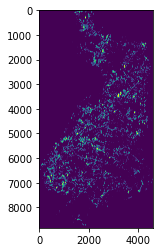

time: 1.46 s (started: 2022-06-06 14:33:10 +02:00)


In [10]:
# Convert from float to integer
intmap = np.rint(totalmap)

import matplotlib.pyplot as plt
plt.imshow(intmap)
predictions=intmap

## Tranformation and save the predictions 
To add geo-reference to the predicted image from the satellite image and saved as a TIFF image.
Use LZW compression to reduce the size of the predicted images.

In [11]:
save_file="Predictions/2014.tif" ##Give the save name to save predicted data in here 
with rasterio.Env():
    profile = image_data.profile
    profile.update(
        dtype=rasterio.int8,
        count=1,
        width= predictions.shape[-1], 
        height= predictions.shape[-2],
        transform= image_data.transform*image_data.transform.scale(0.25,0.25),
        compress='lzw')
    with rasterio.open(save_file, 'w', **profile) as dst:
        dst.write(predictions.astype(rasterio.int8), 1)

time: 456 ms (started: 2022-06-06 14:35:29 +02:00)


## Convert predictions to a shapefile



In [12]:
import geopandas as gpd
mask=predictions==1
results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(predictions, mask=mask, transform=image_data.transform)))

geoms = list(results)
gpd_polygonized_raster = gpd.GeoDataFrame.from_features(geoms)
gpd_polygonized_raster = gpd_polygonized_raster.set_crs(image_data.crs)

gpd_polygonized_raster.to_file("Predictions/2014.shp")
print("Shapefile conversion successful !!!")

Shapefile conversion successful !!!
time: 13 s (started: 2022-06-06 14:35:31 +02:00)
